In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap 

from math import gamma 
from collections import Counter

# 2.1 Binary Variables

<h3>
    $$Bern(x|\mu) = \mu^x(1-\mu)^{1-x}$$ <br>
    <br>
    $$Beta(\mu|a,b) = \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\mu^{a-1}(1-\mu)^{b-1}$$
</h3>

In [2]:
class Binary():
    # posterior distribution for mu 
    def __init__(self,a = 3,b = 3): 
        self.l = a
        self.m = b
    
    def fit(self,X):
        #:param X: 1-D array (N_samples),values should be 0 or 1
        l = np.sum(X)
        m = len(X) - l 
        self.l += l 
        self.m += m
        
    def plot(self):
        x = np.linspace(0,1,100)
        p = np.power(x,self.l-1)*np.power(1 - x,self.m-1)
        p /= p.sum()*0.01
        fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
        axes.plot(x,p)
        axes.set_title(f"Beta(a={self.l},b={self.m})")
        plt.show()     

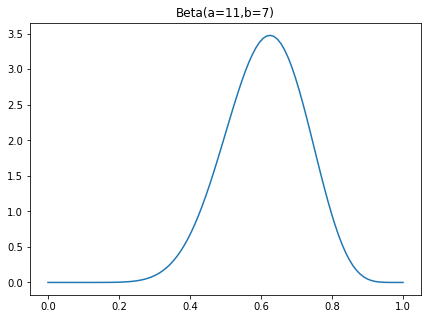

In [3]:
bern = Binary()
X = np.array([1,0,0,0,1,1,1,1,1,1,0,1])
bern.fit(X)
bern.plot()

# 2.2 Multinomial Variables

<h3>
    $$p(\boldsymbol{x}|\boldsymbol{\mu}) = \Pi_{k=1}^K \mu_k^{x_k}$$ <br> 
    <br>
    $$Dir(\boldsymbol{\mu}|\boldsymbol{\alpha}) = \frac{\Gamma(\alpha_0)}{\Gamma(\alpha_1) \cdots \Gamma(\alpha_K)}
    \Pi_{k=1}^K \mu_k^{\alpha_k-1}$$
</h3>

In [4]:
class Multi():
    # posterior distribution for mu
    def __init__(self,K,alpha=None):
        self.K = K 
        self.alpha = alpha if alpha else np.array([1/K]*K)
    
    def fit(self,X):
        #:params X: 2-D array (N_samples,K),values should be 0 or 1 
        N = X.shape[0]
        m = X.sum()
        self.alpha += m/N

# 2.3 The Gaussian Distribution

<h3>
    $$\mathcal{N}(x|\mu,\sigma^2) = \sqrt{\frac{1}{2\pi\sigma^2}}\exp{(-\frac{(x - \mu)^2}{2\sigma^2})}$$<br>
    <br>
    $$\mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu},\boldsymbol{\Sigma}) = \sqrt{\frac{1}{(2\pi)^D|\Sigma|}}\exp{(-\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T\Sigma^{-1}(\boldsymbol{x} - \boldsymbol{\mu}))}$$
</h3>

In [5]:
class Gaussian1D():
    # posterior distribution for mu
    def __init__(self,mu=0,sigma=1):
        self.mu = mu
        self.sigma = sigma
    
    def fit(self,X):
        #:params X: 1-D array (N_samples)
        N = len(X)
        mu_ml = X.mean()
        sigma_ml = X.var()
        self.mu = sigma_ml/(N*self.sigma + sigma_ml)*self.mu + N*self.sigma/(N*self.sigma + sigma_ml)*mu_ml
        self.sigma = 1/(1/self.sigma + N/sigma_ml)
    
    def plot(self):
        x = np.linspace(self.mu - self.sigma*1.5,self.mu + self.sigma*1.5,100)
        p = np.exp(-(x - self.mu)**2/2/self.sigma)
        p /= p.sum()*0.01
        fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
        axes.plot(x,p)
        axes.set_title(f"$Gauss(\mu={self.mu:.2f},\sigma^2={self.sigma:.2f})$")
        plt.show()      

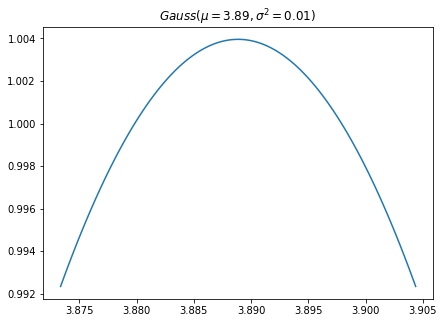

In [6]:
gauss = Gaussian1D()
X = np.random.randn(100) + 4
gauss.fit(X)
gauss.plot()

## Student's t-distribution 

In [7]:
def plot_student(mu,lamda,nu):
    x = np.linspace(mu - 1/lamda*5,mu + 1/lamda*5,100)
    p = np.power(1 + lamda*(x - mu)**2/nu,-(nu + 1)/2)
    p /= p.sum()*0.01 
    fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
    axes.plot(x,p)
    axes.set_title(f"Student's t-distribution($\mu$={mu:.2f},$\lambda$={lamda:.2f},$\\nu$={nu:.2f})")
    plt.show()

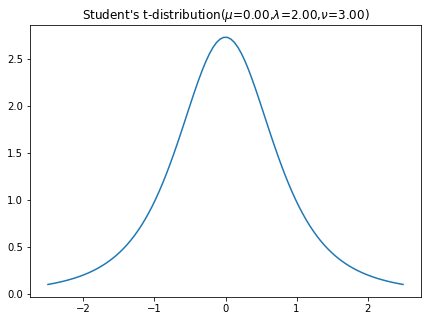

In [8]:
plot_student(0,2,3)

# 2.5 Nonparametric Methods 

In [9]:
class Histgram():
    def __init__(self,delta=0.5):
        self.delta = delta 
    
    def fit(self,X):
        #:params X: 1-D array (N_samples)
        self.X = X 
        self.ma = max(X)
        self.mi = min(X) 
    
    def plot(self):
        fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
        bins = int((self.ma - self.mi)/self.delta) 
        axes.hist(self.X,bins = bins)
        axes.set_title(f"Hist(delta = {self.delta:.2f})")
        plt.show()

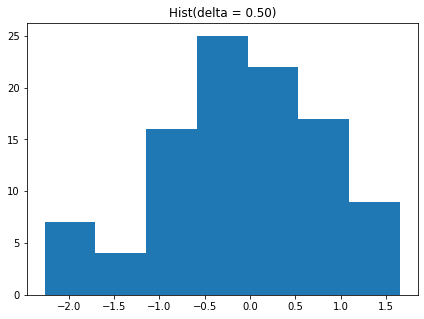

In [10]:
hist = Histgram(delta=5e-1)
X = np.random.randn(100)
hist.fit(X)
hist.plot()

## Kernel density estimators 

In [11]:
class Parzen():
    def __init__(self,kernel = "gauss",h = 0.5):
        #:params kernel: "gauss" or "hist"
        #:params h: the size of window 
        self.kernel = kernel 
        self.h = h
        
    def fit(self,X):
        #:params X: 1-D array (N_samples)
        self.X = X
        self.mi = min(X)
        self.ma = max(X)
    
    def plot(self):
        xs = np.linspace(self.mi-self.h,self.ma+self.h,100)
        p = [0]*100
        if self.kernel == "gauss":
            for i,x in enumerate(xs):
                for x_n in self.X:
                    p[i] += np.exp(-(x - x_n)**2/(2*self.h**2))
                p[i] /= pow(2*np.pi*self.h**2,1/2)
                p[i] /= len(self.X) 
            fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
            axes.plot(xs,p)
            axes.set_title(f"$Parzen(Gauss Kernel)$")
            plt.show()    
            
        elif self.kernel == "hist":
            for i,x in enumerate(xs):
                for x_n in self.X:
                    if abs(x_n - x) < self.h/2:
                        p[i] += 1
                p[i] /= self.h
                p[i] /= len(self.X) 
            fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
            axes.plot(xs,p)
            axes.set_title(f"Parzen(Hist Kernel)")
            plt.show()   

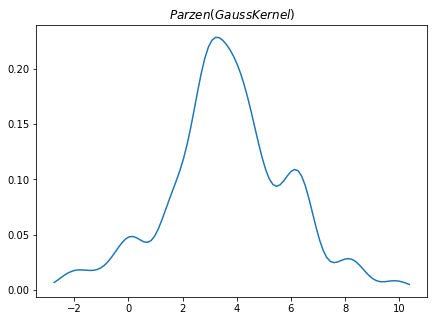

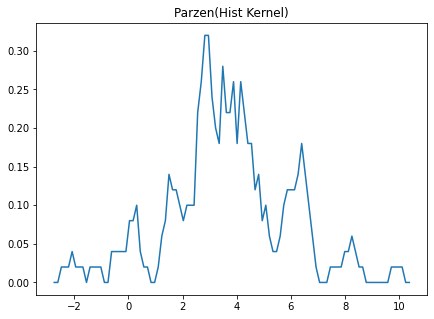

In [12]:
parzen_gauss = Parzen()
X = np.random.randn(100)*2 + 4 
parzen_gauss.fit(X)
parzen_gauss.plot()

parzen_hist = Parzen(kernel = "hist")
parzen_hist.fit(X)
parzen_hist.plot()

## Nearest-neighbor methods

In [13]:
class KNearestNeighbor():
    def __init__(self,k=5):
        #:params k: number of point in the neighbor 
        self.k = k 
    def fit(self,X):
        #:params X: 1-D array (N_samples)
        self.X = X 
        self.mi = min(X)
        self.ma = max(X)
    def plot(self):
        xs = np.linspace(self.mi-0.1,self.ma+0.1,100)
        p = [0]*100
        for i,x in enumerate(xs):
            dist = abs(self.X - x)
            dist.sort() 
            h = dist[self.k-1]
            p[i] = self.k/len(self.X)/h
        fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
        axes.plot(xs,p)
        axes.set_title(f"KNearestNeighbor(k={self.k})")
        plt.show()    

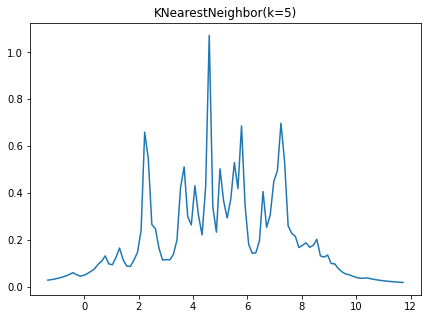

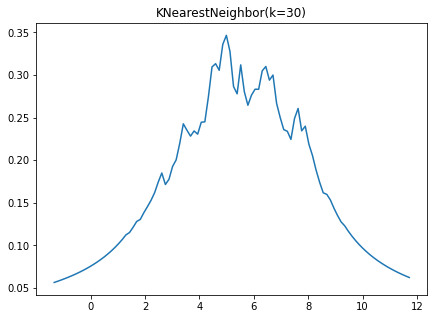

In [14]:
knn5 = KNearestNeighbor(k=5)
knn30 = KNearestNeighbor(k=30)
X = np.random.randn(100)*2.4 + 5.1
knn5.fit(X)
knn5.plot()
knn30.fit(X)
knn30.plot()

In [15]:
color = ["red","blue","lightgreen","yellow","orange","purple","pink"] 

class KNeighborClassifier():
    def __init__(self,k=10):
        self.k = k
        
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,2) 
        #:params y: 1-D array (N_samples) label-encoding 
        self.X = X 
        self.y = y
    
    def predict(self,X):
        #:params X: 2-D array (N_samples,2) 
        pred_y = [0]*len(X)
        for i,(a,b) in enumerate(X):
            dist_label = [((a-x)**2+(b-y)**2,label) for (x,y),label in zip(self.X,self.y)]
            dist_label.sort() 
            k_neighbor = [label for d,label in dist_label[:self.k]]
            k_neighbor_label = Counter(k_neighbor).most_common(1)[0][0]
            pred_y[i] = k_neighbor_label
        return np.array(pred_y)
        
    def plot(self):
        cmap = ListedColormap(color[:len(np.unique(self.y))])
        x_min,y_min = self.X.min(axis = 0)
        x_max,y_max = self.X.max(axis = 0) 
        x_min,y_min = x_min-0.1,y_min-0.1
        x_max,y_max = x_max+0.1,y_max+0.1
        x = np.linspace(x_min,x_max,100)
        y = np.linspace(y_min,y_max,100) 
        xs,ys = np.meshgrid(x,y)
        labels = self.predict(np.array([xs.ravel(),ys.ravel()]).T)
        labels = labels.reshape(xs.shape)
        
        plt.contourf(xs,ys,labels,alpha=0.3,cmap=cmap)
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        for idx,label in enumerate(np.unique(self.y)):
            plt.scatter(x=self.X[self.y == label,0],
                        y=self.X[self.y == label,1],
                        alpha=0.8,
                        c=color[idx],
                        label=label)
        plt.legend()
        plt.show()

In [16]:
def load_iris():
    dict = {
        "Iris-setosa": 0,
        "Iris-versicolor": 1,
        "Iris-virginica": 2
    }
    X = []
    y = [] 
    with open("../data/iris.data") as f:
        data = f.read()
    
    for line in data.split("\n"):
        # sepal length | sepal width | petal length | petal width 
        if len(line) == 0:
            continue
        sl,sw,pl,pw,cl = line.split(",")
        rec = np.array(list(map(float,(sl,sw,pl,pw))))
        cl = dict[cl]

        X.append(rec)
        y.append(cl)
    return np.array(X),np.array(y)

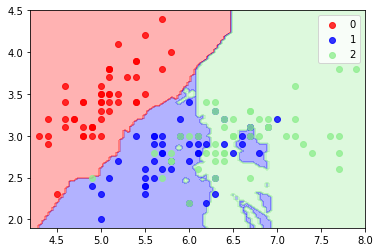

In [17]:
X,y = load_iris()
X = X[:,:2]

knn10 = KNeighborClassifier()
knn10.fit(X,y)
knn10.plot()

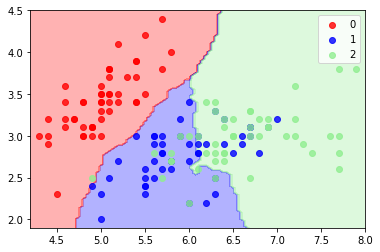

In [18]:
knn30 = KNeighborClassifier(k=30)
knn30.fit(X,y)
knn30.plot()